# TP 2 : Apprentissage de champ de vecteur

In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

## Partie 1. (apprentissage direct)

1. 

In [57]:
def make_data(nb_data):
    x_train = 2 * torch.rand(nb_data, 2, dtype=torch.double)
    x1 = x_train[:, 0]
    x2 = x_train[:, 1]
    v1 = x1 - x1 * x2
    v2 = x1 * x2 - x2
    v_train = torch.stack([v1, v2], dim=1)
    return x_train, v_train

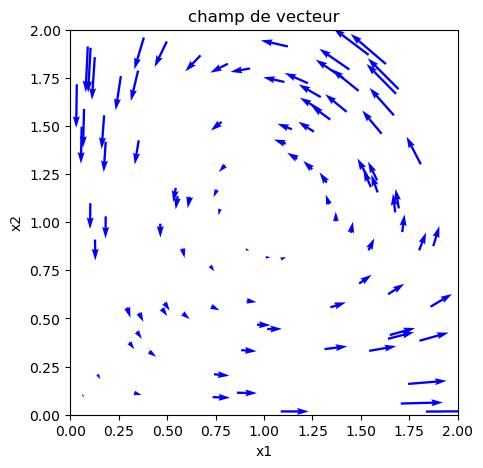

In [58]:
def test_make_data():
    nb_data = 100
    x_train, v_train = make_data(nb_data)
    x_train_np = x_train.numpy()
    v_train_np = v_train.numpy()
    plt.figure(figsize=(5, 5))
    plt.quiver(x_train_np[:, 0], x_train_np[:, 1],
               v_train_np[:, 0], v_train_np[:, 1],
               color='b')
    plt.title("champ de vecteur")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(0, 2)
    plt.ylim(0, 2)
    plt.show()

test_make_data()


In [59]:
class mlp(torch.nn.Module):
    def __init__(self, layer_widths = list):
        super().__init__()

        self.layer_widths = layer_widths
        
        self.hidden_layers = []
        for i in range(len(layer_widths)-1):
            self.hidden_layers.append(torch.nn.Linear(self.layer_widths[i], self.layer_widths[i+1], dtype=torch.double))

        self.hidden_layers = torch.nn.ModuleList(self.hidden_layers)
        self.activation = torch.nn.Tanh()

    def forward(self, inputs):
        for i in range(len(self.layer_widths)-1):
                inputs = self.activation(self.hidden_layers[i].forward(inputs))
        return inputs

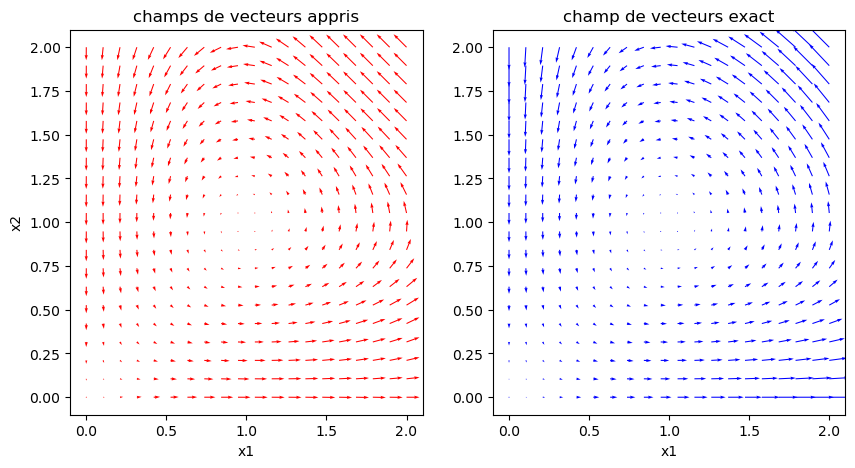

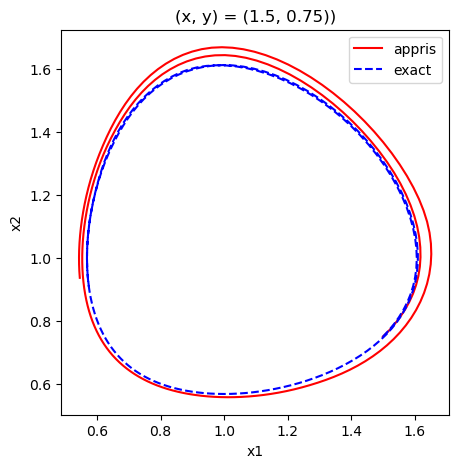

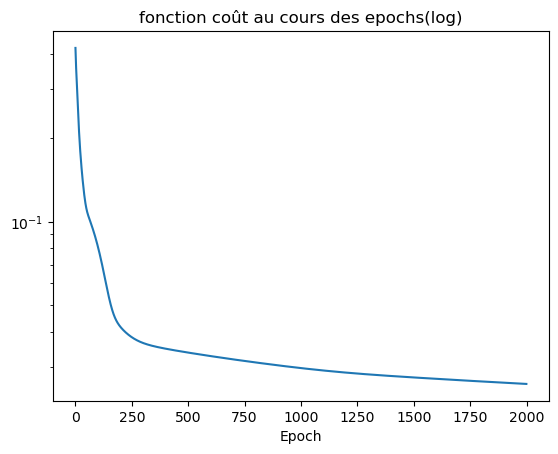

In [60]:
class vectorfield_learning:
    def __init__(self, nb_epochs=1000, lr=1e-3):
        layer_widths = [2, 50, 50, 2]
        self.network = mlp(layer_widths)
        self.nb_epochs = nb_epochs
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.network.parameters(), lr=lr)

    def train(self, x_train, v_train):
        self.network.train()
        losses = []
        for epoch in range(self.nb_epochs):
            self.optimizer.zero_grad()
            output = self.network(x_train)
            loss = self.criterion(output, v_train)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
        return losses
    
    def plot(self):
        self.network.eval()
        x1 = np.linspace(0, 2, 20)
        x2 = np.linspace(0, 2, 20)
        X1, X2 = np.meshgrid(x1, x2)

        X_test = np.vstack([X1.ravel(), X2.ravel()]).T
        X_test_tensor = torch.from_numpy(X_test).double()
        
        with torch.no_grad():
            v_pred = self.network(X_test_tensor).numpy()

        x1_exact = X_test[:,0]
        x2_exact = X_test[:,1]
        v1_exact = x1_exact - x1_exact * x2_exact
        v2_exact = x1_exact * x2_exact - x2_exact

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.quiver(X_test[:, 0], X_test[:, 1], v_pred[:, 0], v_pred[:, 1],
                   color='r')
        plt.title("champs de vecteurs appris")
        plt.xlabel("x1")
        plt.ylabel("x2")
        
        plt.subplot(1, 2, 2)
        plt.quiver(X_test[:, 0], X_test[:, 1], v1_exact, v2_exact,
                   color='b')
        plt.title("champ de vecteurs exact")
        plt.xlabel("x1")
        plt.show()
        
        def f_appris(t, x):
            x_tensor = torch.tensor(x, dtype=torch.double)
            with torch.no_grad():
                v = self.network(x_tensor).numpy()
            return v
        
        def f_exact(t, x):
            x1, x2 = x
            return [x1 - x1 * x2, x1 * x2 - x2]
        
        t_span = (0, 10)
        x0 = [1.5, 0.75]
        t_eval = np.linspace(0, 10, 200)
        sol_appris = solve_ivp(f_appris, t_span, x0, t_eval=t_eval)
        sol_exact = solve_ivp(f_exact, t_span, x0, t_eval=t_eval)

        plt.figure(figsize=(5, 5))
        plt.plot(sol_appris.y[0], sol_appris.y[1], 'r-', label='appris')
        plt.plot(sol_exact.y[0], sol_exact.y[1], 'b--', label='exact')
        plt.title("(x, y) = (1.5, 0.75))")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.show()
        
    
def test_vector_field_learning():
    nb_data = 1000
    x_train, v_train = make_data(nb_data)
    model = vectorfield_learning(nb_epochs=2000, lr=1e-3)
    losses = model.train(x_train, v_train)
    model.plot()

    plt.figure()
    plt.plot(losses)
    plt.title("fonction coût au cours des epochs(log)")
    plt.xlabel("Epoch")
    plt.yscale("log")
    plt.show()

test_vector_field_learning()